In [9]:
import numpy as np
import os
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image

 ## 1. Подкотовка данных к обучению 

1. Разобьем исходную mel-спектограмму на временные интервалы. Временнной интервал возьмем равным 80.

In [10]:
dir_path ="train/clean"

In [11]:
np.ceil(2.01)

3.0

In [12]:
def padding_left(numpy_image, frame_size):
    result_image = np.zeros((frame_size,numpy_image.shape[1])).astype(np.float16)
    result_image[:numpy_image.shape[0],:] =numpy_image
    return result_image    

In [13]:
def cut_image_into_frames(numpy_image, frame_size):
    if (numpy_image.shape[0]< frame_size):
        result_image =padding_left(numpy_image, frame_size)
        return [result_image]
    elif(numpy_image.shape[0]== frame_size):
        return [numpy_image]
    else:
        results =[]
        frame_number =int(np.ceil(numpy_image.shape[0]/frame_size))
        for frame_id in range(0,frame_number):
            if(numpy_image.shape[0]>=(frame_id+1)*frame_size):
                result_image=numpy_image[frame_id*frame_size:(frame_id+1)*frame_size, :]
                results.append(result_image)
            else:
                result_image=padding_left(numpy_image[frame_id*frame_size:, :],frame_size)
                results.append(result_image)
        return results       

In [14]:
def combine_frames(result_paths, size):
    results =[]
    for result in result_paths:
        results.append(np.load(result))
    result_frame =np.concatenate(results, axis=0)
    return result_frame[:size, :]

In [15]:
def combine_frames_v2(results, size):
    result_frame =np.concatenate(results, axis=0)
    return result_frame[:size, :]

2. Проверим, что разделение формируется корректно

In [16]:
train_image_clean =np.load("val/clean/8156/8156_104526_8156-104526-0014.npy")
train_image_noisy =np.load("val/noisy/8156/8156_104526_8156-104526-0014.npy")

In [17]:
results=cut_image_into_frames(train_image_clean, 80)

In [18]:
old_train =combine_frames_v2(results, train_image_clean.shape[0])

In [19]:
np.array_equal(old_train,train_image_clean)

True

## Формирование датасета для обучения, состоящего из нарезанных аудио 

In [20]:
import pandas as pd

In [81]:
def normalize_data(numpy_array):
        numpy_array =(numpy_array -numpy_array.min())/ (numpy_array.max()- numpy_array.min()) *255
        return numpy_array.astype(np.uint8)

In [82]:
def generate_dataset_for_denoising(root_dir,frame_size):
    clean_path ="clean"
    noisy_path ="noisy"
    train_mels =[]
    new_root_dir =root_dir +"_frames"
    if(not os.path.exists(new_root_dir)):
        os.mkdir(new_root_dir)
        os.mkdir(os.path.join(new_root_dir, clean_path))
        os.mkdir(os.path.join(new_root_dir, noisy_path))
        
    train_packages =os.listdir(os.path.join(root_dir, clean_path))
    denoising_dataset =[]
    for train_package in train_packages:
        clean_package =os.path.join(root_dir,clean_path,train_package)
        new_clean_package = os.path.join(new_root_dir,clean_path,train_package)
        new_noisy_package = os.path.join(new_root_dir,noisy_path,train_package)
        if(not os.path.exists(new_clean_package)):
            os.mkdir(new_clean_package)
            os.mkdir(new_noisy_package)
        mel_files =os.listdir(clean_package)
        for mel_file in mel_files:
            path_clean =os.path.join(clean_package,mel_file)
            path_noise =os.path.join(root_dir,noisy_path,train_package, mel_file)
            
            path_package =mel_file.split(".")[0]
            
            path_clean_package = os.path.join(new_clean_package,path_package)
            path_noise_package =os.path.join(new_noisy_package,path_package)
            
            if(not os.path.exists(path_clean_package)):
                os.mkdir(path_clean_package)
            if(not os.path.exists(path_noise_package)):
                os.mkdir(path_noise_package)
                
            mel_clean =np.load(path_clean)
            mel_noise =np.load(path_noise)
            mel_clean_frames =cut_image_into_frames(mel_clean, frame_size)
            mel_noise_frames =cut_image_into_frames(mel_noise, frame_size)        
            for i, (mel_clean_frame,mel_noise_frame) in  enumerate(zip(mel_clean_frames,mel_noise_frames)):
                    first_name =mel_file.split(".")[0]
                    mel_clean_frame_path = os.path.join(path_clean_package,first_name+"_"+str(i) +".npy")
                    mel_noise_frame_path =os.path.join(path_noise_package,first_name+"_"+str(i) +".npy")
                    np.save(mel_clean_frame_path, mel_clean_frame) 
                    np.save(mel_noise_frame_path, mel_noise_frame)
                    mel_entity ={"mel_clean_frame_path" : mel_clean_frame_path, "mel_noise_frame_path": mel_noise_frame_path, "study_id": first_name}
                    denoising_dataset.append(mel_entity)        
    return denoising_dataset

In [84]:
denoising_dataset =generate_dataset_for_denoising("train",80)

In [85]:
train_data =pd.DataFrame().from_dict(denoising_dataset)

In [86]:
train_data= pd.read_csv("denoising_dataset.csv")

4. Проверим, что данные сгенерировались корректно

In [88]:
result_paths=list(train_data.loc[train_data["study_id"]=="20_205_20-205-0004"]["mel_clean_frame_path"].values)

In [97]:
train_old =combine_frames(result_paths, 875)

In [90]:
train_old.dtype

dtype('float16')

In [91]:
train_image_clean

array([[ 0.5195,  0.1609,  0.1993, ..., -0.3667, -0.3923, -0.3987],
       [ 0.5166,  0.2693,  0.2184, ..., -0.2974, -0.3953, -0.362 ],
       [ 0.4285,  0.2668,  0.1334, ..., -0.287 , -0.3647, -0.3606],
       ...,
       [ 0.4836,  0.24  ,  0.1538, ..., -0.3518, -0.3894, -0.3948],
       [ 0.4263,  0.352 ,  0.2025, ..., -0.3296, -0.4255, -0.4363],
       [ 0.507 ,  0.3787,  0.2098, ..., -0.2905, -0.3987, -0.404 ]],
      dtype=float16)

In [99]:
train_old =normalize_data(train_old)

In [93]:
train_old

array([[129,  82,  87, ...,  14,  10,   9],
       [129,  97,  90, ...,  23,  10,  14],
       [117,  96,  79, ...,  24,  14,  14],
       ...,
       [125,  93,  82, ...,  15,  11,  10],
       [117, 107,  88, ...,  18,   6,   4],
       [128, 111,  89, ...,  23,   9,   9]], dtype=uint8)

In [100]:
train_image_clean =normalize_data(train_old)

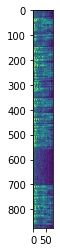

In [101]:
plt.imshow(train_image_clean)

In [102]:
train_old

array([[129,  82,  87, ...,  14,  10,   9],
       [129,  97,  90, ...,  23,  10,  14],
       [117,  96,  79, ...,  24,  14,  14],
       ...,
       [125,  93,  82, ...,  15,  11,  10],
       [117, 107,  88, ...,  18,   6,   4],
       [128, 111,  89, ...,  23,   9,   9]], dtype=uint8)

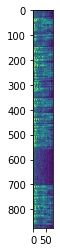

In [103]:
plt.imshow(train_old)

In [104]:
train_old.shape

(875, 80)

In [105]:
np.array_equal(train_old,train_image_clean)

True